In [1]:
import json
import pickle 
import os
import random
import itertools
# for dirname, _, filenames in os.walk('LYMPHOMADataset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# from tensorflow.keras.layers.experimental  import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [3]:

def get_image_paths(directory,lable):
    """
    Function to get  image paths from a directory.
    """
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'tif')):  # Adjust file extensions as needed
                image_paths.append(os.path.join(root, file))
    
    df_paths = pd.DataFrame({'path': image_paths, 'label': lable})
    
    return df_paths

In [4]:
df_ML_cll = get_image_paths('LYMPHOMADataset/CLL','cll')
df_ML_fl = get_image_paths('LYMPHOMADataset/FL','fl')
df_ML_mcl= get_image_paths('LYMPHOMADataset/MCL','mcl')

In [5]:
df_train_cll , df_test_cll= df_ML_cll[37:] , df_ML_cll[0:37]
df_train_fl , df_test_fl=  df_ML_fl[37:] ,df_ML_fl[0:37] 
df_train_mcl , df_test_mcl= df_ML_mcl[37:] ,  df_ML_mcl[0:37]

In [6]:
df_train =  pd.concat([df_train_cll, df_train_fl,df_train_mcl], axis=0, join='inner')
df_test = pd.concat([df_test_cll, df_test_fl,df_test_mcl], axis=0, join='inner')

In [7]:
df_train.to_csv('df_train.csv', index=False) 
df_test.to_csv('df_test.csv', index=False) 

In [8]:
train_path = pd.read_csv('df_train.csv')
test_path = pd.read_csv('df_test.csv')

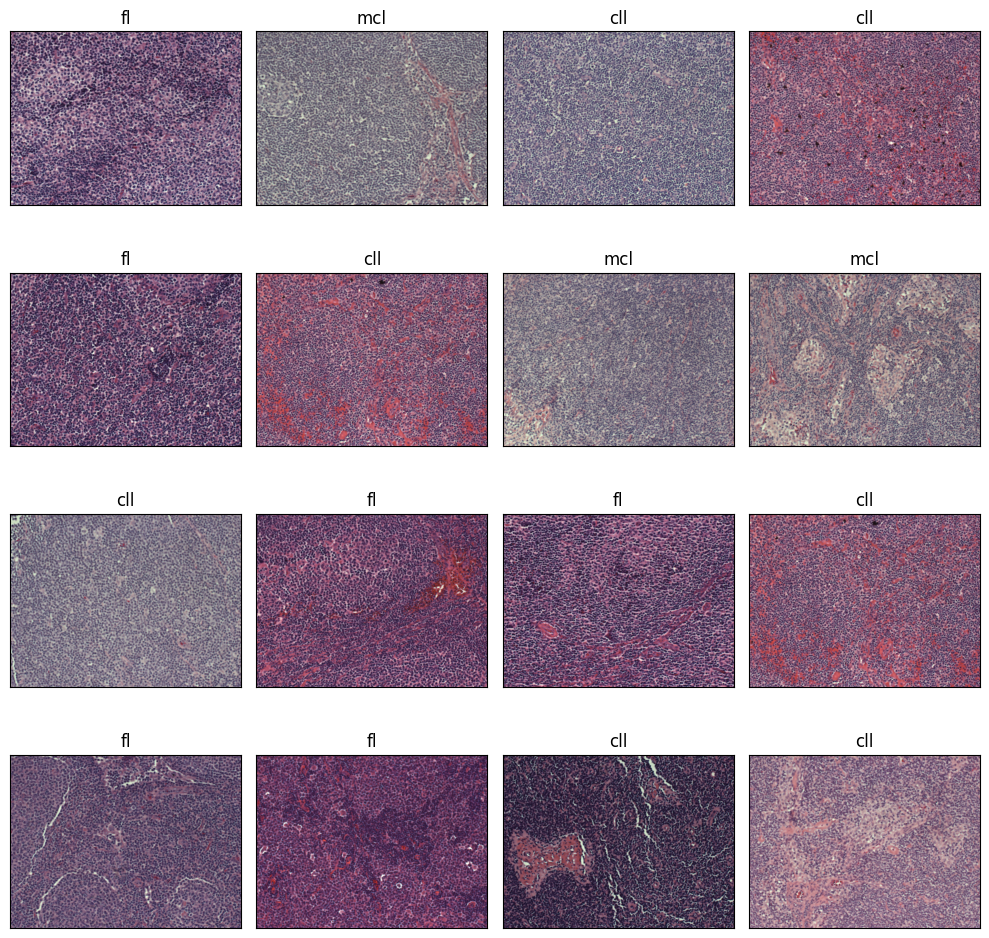

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(train_path), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_path.path[random_index[i]]))
    ax.set_title(train_path.label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
train_df = train_path
test_df = test_path

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
bt_size = 8

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 211 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.
Found 111 validated image filenames belonging to 3 classes.


# Augment and load model

In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),

  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

C:\Users\rahul.kumar1\AppData\Local\Temp\ipykernel_23304\1801080964.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(


In [15]:
# Create checkpoint callback
checkpoint_path = 'lymphoma_classification_best.keras'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                    #   save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

In [17]:
# import urllib.request

# # URL of the file to download
# url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# # Destination path to save the downloaded file
# destination_path = 'helper_functions.py'

# # Download the file
# urllib.request.urlretrieve(url, destination_path)

# print("File downloaded successfully.")

In [18]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [19]:
num_loop = 10
train_history = {}  # Initialize an empty dictionary

for i in range(num_loop):
    # Load the pretained model
    pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
    )

    pretrained_model.trainable = False
    inputs = pretrained_model.input
    x = resize_and_rescale(inputs)
    x = Dense(256, activation='relu')(pretrained_model.output)
    x = Dropout(0.45)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)

    # Class 
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(0.00001),
        loss='categorical_crossentropy',
        # metrics=['mean_squared_error']
        metrics=['accuracy']
    )
    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("logs", 
                                        "lymphoma_classification"),
            checkpoint_callback,
        ]
    )
    results = model.evaluate(test_images, verbose=0)
    pred = model.predict(test_images)
    pred = np.argmax(pred,axis=1)
    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Collect training history
    train_history[i] = {
        'predicted': pred,  # Assuming 'pred' is defined elsewhere
        'accuracy': results[1] * 100,
        'test_loss': results[0],
        'accuracy_history': history.history['accuracy'],
        'loss_history': history.history['loss'],
        'val_accuracy_history': history.history['val_accuracy'],
        'val_loss_history': history.history['val_loss']
    }
    print(f'ending loop {i}')
    
with open('lymphomaModel.pkl', 'wb') as f:
    pickle.dump(train_history, f)

C:\Users\rahul.kumar1\AppData\Local\Temp\ipykernel_23304\4159662488.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(


Saving TensorBoard log files to: logs/lymphoma_classification/20240408-021406
Epoch 1/100


c:\Users\rahul.kumar1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.3150 - loss: 3.4424 - val_accuracy: 0.1923 - val_loss: 1.9339
Epoch 2/100


c:\Users\rahul.kumar1\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3357 - loss: 3.2712 - val_accuracy: 0.1154 - val_loss: 2.1773
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3318 - loss: 2.6813 - val_accuracy: 0.0385 - val_loss: 2.4479
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4104 - loss: 2.5733 - val_accuracy: 0.0385 - val_loss: 2.7891
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3705 

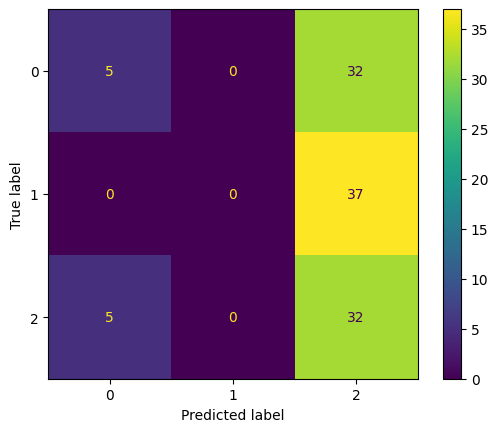

              precision    recall  f1-score   support

         cll       0.50      0.14      0.21        37
          fl       0.00      0.00      0.00        37
         mcl       0.32      0.86      0.46        37

    accuracy                           0.33       111
   macro avg       0.27      0.33      0.23       111
weighted avg       0.27      0.33      0.23       111



c:\Users\rahul.kumar1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul.kumar1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul.kumar1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [23]:
from sklearn import metrics

predited_value = train_history[2]['predicted']

y_test  = list(test_df.label)
confusion_matrix = metrics.confusion_matrix(y_test,predited_value )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()
print(classification_report(y_test, predited_value))

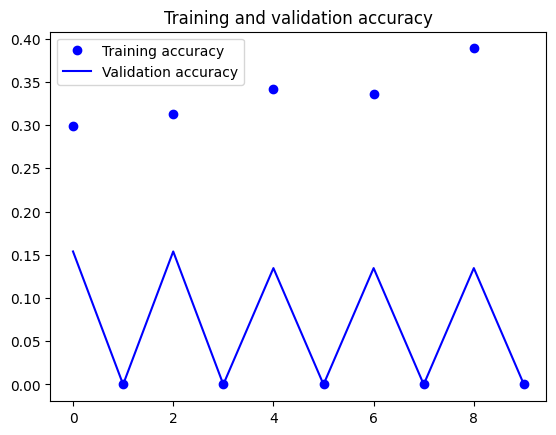

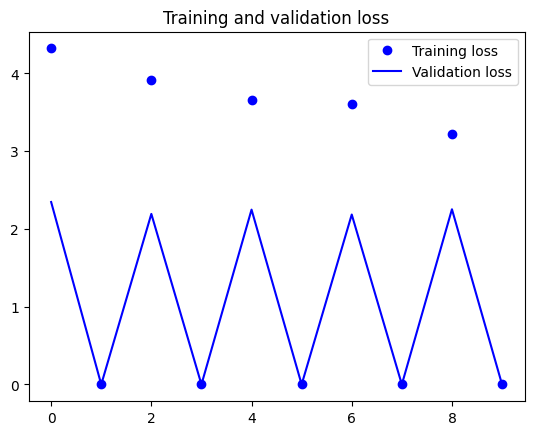

In [24]:
num = 2

accuracy_plt = train_history[num]['accuracy_history']
val_accuracy_plt = train_history[num]['val_accuracy_history']

loss_plt = train_history[num]['loss_history']
val_loss_plt = train_history[num]['val_loss_history']

epochs = range(len(accuracy_plt))
plt.plot(epochs, accuracy_plt, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_plt, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss_plt, 'bo', label='Training loss')
plt.plot(epochs, val_loss_plt, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()